In [1]:
# Copyright 2020 NVIDIA Corporation. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ==============================================================================

<img src="http://developer.download.nvidia.com/compute/machine-learning/frameworks/nvidia_logo.png" style="width: 90px; float: right;">

## Overview

NVTabular is a feature engineering and preprocessing library for tabular data designed to quickly and easily manipulate terabyte scale datasets used to train deep learning based recommender systems.  It provides a high level abstraction to simplify code and accelerates computation on the GPU using the RAPIDS cuDF library.<br><br>

### Learning Objectives

In this notebook, we show how to

- do preprocessing with NVTabular
- serialize and save a workflow to load later to transform new dataset
- train a TF MLP model and save it in the /models directory.
- save the ensemble model to be used at the deployment stage.

### MovieLens25M

The [MovieLens25M](https://grouplens.org/datasets/movielens/25m/) is a popular dataset for recommender systems and is used in academic publications. The dataset contains 25M movie ratings for 62,000 movies given by 162,000 users. Many projects use only the user/item/rating information of MovieLens, but the original dataset provides metadata for the movies, as well. For example, which genres a movie has. Although we may not improve state-of-the-art results with our neural network architecture, the purpose of this notebook is to explain how to save an ensemble model which consists of NVTabular workflow and Tensorflow model to be used later at model deployment stage.

## Getting Started

In [1]:
import os, time
os.environ["CUDA_VISIBLE_DEVICES"]="0,1"

In [2]:
# External dependencies
import cudf                 # cuDF is an implementation of Pandas-like Dataframe on GPU
import time
import gc

import pandas as pd
import numpy as np
import nvtabular as nvt

from os import path
from sklearn.model_selection import train_test_split

In [6]:
# path to store raw and preprocesses data
BASE_DIR = './'

We define our base directory, containing the data.

If the data is not available in the base directory, we will download and unzip the data.

In [5]:
if not path.exists(BASE_DIR + 'ml-25m'):
    if not path.exists(BASE_DIR + 'ml-25m.zip'):
        os.system("wget http://files.grouplens.org/datasets/movielens/ml-25m.zip")
        os.system("mv ml-25m.zip " + BASE_DIR)
    os.system("unzip " + BASE_DIR + "ml-25m.zip -d " + BASE_DIR)

## Preparing the dataset with NVTabular

First, we take a look on the movie metadata. 

We load the movie ratings.

In [6]:
ratings = cudf.read_csv(os.path.join(BASE_DIR, "ml-25m", "ratings.csv"))
ratings.head()

,userId,movieId,rating,timestamp
0,1,296,5.0,1147880044
1,1,306,3.5,1147868817
2,1,307,5.0,1147868828
3,1,665,5.0,1147878820
4,1,899,3.5,1147868510


We drop the timestamp column and split the ratings into training and test dataset. We use a simple random split.

In [7]:
ratings = ratings.drop('timestamp', axis=1)
train, valid = train_test_split(ratings, test_size=0.2, random_state=42)

In [8]:
train.head()

,userId,movieId,rating
19120594,124027,56587,4.0
15253127,98809,2641,2.5
12584278,81377,122886,4.5
18034326,116853,78499,4.5
18073299,117118,1302,2.5


In [9]:
train.shape

(20000076, 3)

In [10]:
train.to_parquet(BASE_DIR + 'train.parquet')
valid.to_parquet(BASE_DIR + 'valid.parquet')

First, we need to define our NVTabular processing pipelines. NVTabular has already implemented multiple calculations, called `ops`. An `op` can be applied to a `ColumnGroup` from an overloaded `>>` operator, which in turn returns a new `ColumnGroup`. A `ColumnGroup` is a list of column names as text.<br><br>
**Example:**<br>
features = [*\<column name\>*, ...] >> *\<op1\>* >> *\<op2\>* >> ...

Embedding Layers of neural networks require, that categorial features are continuous, incremental Integers: 0, 1, 2, ... , |C|-1. We need to ensure that our categorical features fullfil the requirement.<br>

We should transform the single-hot categorical features userId and movieId.<br>

NVTabular provides the operator `Categorify`, which provides this functionality with a high-level API out of the box. In NVTabular release v0.3, list support was added for multi-hot categorical features. Both works in the same way with no need for changes.

Next, we will add `Categorify`  for our categorical features, userId, movieId.

In [11]:
cat_names = ['userId', 'movieId']

cat_features = cat_names >> nvt.ops.Categorify(cat_cache="device")

The ratings are on a scale between 1-5. We want to predict a binary target with 1 are all ratings `>=4` and 0 are all ratings `<=3`. We use the [LambdaOp](https://nvidia.github.io/NVTabular/main/api/ops/lambdaop.html) for it.

In [12]:
ratings = nvt.ColumnGroup(['rating']) >> (lambda col: (col>3).astype('int8'))

We can visualize our calculation graph.

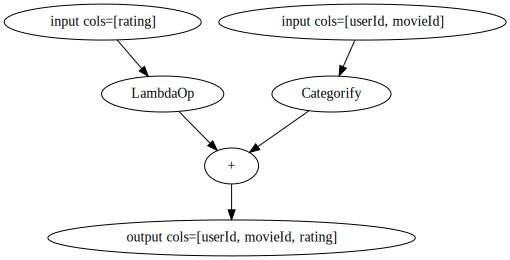

In [13]:
output = cat_features+ratings
(output).graph

We initialize our NVTabular `workflow`.

In [14]:
workflow = nvt.Workflow(output)

We initialize NVTabular Datasets. First, we save it to a parquet file, that we can use the `part_size` parameter in `nvt.Dataset`. We want to have multiple output files and therefore, we need to use multiple partition by loading the dataset from disk. 

In [15]:
del train
del valid
gc.collect()

34

In [23]:
CATEGORICAL_COLUMNS = ['userId', 'movieId']
LABEL_COLUMNS = ['rating']

In [24]:
dict_dtypes={}

for col in CATEGORICAL_COLUMNS:
    dict_dtypes[col] = np.int64
    
for col in LABEL_COLUMNS:
    dict_dtypes[col] = np.float32

In [25]:
train_dataset = nvt.Dataset(BASE_DIR + '/ml-25m/train.parquet', part_size='100MB')
valid_dataset = nvt.Dataset(BASE_DIR + '/ml-25m/valid.parquet', part_size='100MB')

First, we collect the training dataset statistics.

In [26]:
%%time

workflow.fit(train_dataset)

CPU times: user 1.12 s, sys: 417 ms, total: 1.54 s
Wall time: 1.68 s


We clear our output directories.

In [27]:
!rm -r $BASE_DIR/train
!rm -r $BASE_DIR/valid

rm: cannot remove './/train': No such file or directory
rm: cannot remove './/valid': No such file or directory


In [7]:
output_train_dir=BASE_DIR + '/ml-25m/train/'
output_valid_dir=BASE_DIR + '/ml-25m/valid/'

We transform our workflow with `.transform`.

In [29]:
%time

workflow.transform(train_dataset).to_parquet(output_path=output_train_dir, dtypes=dict_dtypes, cats=CATEGORICAL_COLUMNS, labels=LABEL_COLUMNS)

workflow.transform(valid_dataset).to_parquet(output_path=output_valid_dir, 
                                             dtypes=dict_dtypes,
                                             cats=CATEGORICAL_COLUMNS,
                                             labels=LABEL_COLUMNS,
                                             shuffle=False)

CPU times: user 4 µs, sys: 3 µs, total: 7 µs
Wall time: 20.7 µs


We can take a look in the output dir.

## TensorFlow: Training Neural Network

### Reviewing data

We can take a look on the data.

In [10]:
import glob

TRAIN_PATHS = sorted(glob.glob(output_train_dir + '*.parquet'))
# VALID_PATHS = sorted(glob.glob(BASE_DIR + 'valid/*.parquet'))
TRAIN_PATHS

['.//ml-25m/train/0.e0c5959510a4481e8e320f9480195226.parquet']

We can see that our ratings are of only 0 and 1 after preprocessing.

In [11]:
df = cudf.read_parquet(TRAIN_PATHS[0])
df.head()

,userId,movieId,rating
0,124027,11994,1.0
1,98809,2550,0.0
2,81377,24262,1.0
3,116853,14786,1.0
4,117118,1269,0.0


In [12]:
df.dtypes

userId       int64
movieId      int64
rating     float32
dtype: object

In [15]:
# calculate cardinalities to assign 
# as slot_size_array in the model json file
cardinalities = []
for col in ['userId', 'movieId']:
    print(df[col].nunique())
    cardinalities.append(df[col].nunique())

162541
56585


In [16]:
print(cardinalities)

[162541, 56585]


In [17]:
total_card = sum(cardinalities)
total_card

219126

In [23]:
del df
gc.collect()

638

# TRAIN HUGECTR

In [3]:
%%writefile '/nvtabular/examples/movielens_config.json'

{
  "solver": {
    "lr_policy": "fixed",
    "display": 200,
    "max_iter": 10200,
    "gpu": [2,3],
    "batchsize": 2048,
    "snapshot": 10000,
    "snapshot_prefix": "./1/",
    "eval_interval": 1000,
    "max_eval_batches": 300,
    "input_key_type": "I64"
  },
  "optimizer": {
    "type": "Adam",
    "update_type": "Global",
    "adam_hparam": {
      "learning_rate": 0.001,
      "beta1": 0.9,
      "beta2": 0.999,
      "epsilon": 0.0000001
    }
  },
  "layers": [
    {
      "name": "data",
      "type": "Data",
      "format": "Parquet",
      "slot_size_array": [162541, 56585],
      "source": "/working_dir/movie/data/train/_file_list.txt",
      "eval_source": "/working_dir/movie/data/valid/_file_list.txt",
      "check": "Sum",
      "label": {
        "top": "label",
        "label_dim": 1
      },
      "dense": {
        "top": "dense",
        "dense_dim": 0
      },
      "sparse": [
        {
          "top": "data1",
          "type": "DistributedSlot",
          "max_feature_num_per_sample": 3,
          "slot_num": 2
        }
      ]
    },
    {
      "name": "sparse_embedding1",
      "type": "DistributedSlotSparseEmbeddingHash",
      "bottom": "data1",
      "top": "sparse_embedding1",
      "sparse_embedding_hparam": {
        "max_vocabulary_size_per_gpu": 219126,
        "embedding_vec_size": 64,
        "combiner": 0
      }
    },
    {
      "name": "reshape1",
      "type": "Reshape",
      "bottom": "sparse_embedding1",
      "top": "reshape1",
      "leading_dim": 128
    },
    {
      "name": "fc1",
      "type": "InnerProduct",
      "bottom": "reshape1",
      "top": "fc1",
      "fc_param": {
        "num_output": 128
      }
    },
    {
      "name": "relu1",
      "type": "ReLU",
      "bottom": "fc1",
      "top": "relu1"
    },
    {
      "name": "fc2",
      "type": "InnerProduct",
      "bottom": "relu1",
      "top": "fc2",
      "fc_param": {
        "num_output": 128
      }
    },
    {
      "name": "relu2",
      "type": "ReLU",
      "bottom": "fc2",
      "top": "relu2"
    },
    {
      "name": "fc3",
      "type": "InnerProduct",
      "bottom": "relu2",
      "top": "fc3",
      "fc_param": {
        "num_output": 128
      }
    },
    {
      "name": "relu3",
      "type": "ReLU",
      "bottom": "fc3",
      "top": "relu3"
    },
    {
      "name": "fc4",
      "type": "InnerProduct",
      "bottom": "relu3",
      "top": "fc4",
      "fc_param": {
        "num_output": 1
      }
    },
    {
      "name": "loss",
      "type": "BinaryCrossEntropyLoss",
      "bottom": [
        "fc4",
        "label"
      ],
      "top": "loss"
    }
  ]
}

Writing /nvtabular/examples/movielens_config.json


In [4]:
!mkdir ./1/

In [9]:
!huge_ctr --train ./movielens_config.json

[0.001, init_start, ]
HugeCTR Version: 3.0.0
Config file: ./movielens_config.json
[26d22h01m40s][HUGECTR][INFO]: batchsize_eval is not specified using default: 2048
[26d22h01m40s][HUGECTR][INFO]: enable_tf32_compute is not specified using default: 0
[26d22h01m40s][HUGECTR][INFO]: TF32 Compute: OFF
[26d22h01m40s][HUGECTR][INFO]: Default evaluation metric is AUC without threshold value
[26d22h01m40s][HUGECTR][INFO]: algorithm_search is not specified using default: 1
[26d22h01m40s][HUGECTR][INFO]: Algorithm search: ON
[26d22h01m40s][HUGECTR][INFO]: cuda_graph is not specified using default: 1
[26d22h01m40s][HUGECTR][INFO]: CUDA Graph: ON
[26d22h01m40s][HUGECTR][INFO]: Export prediction: OFF
[26d22h01m40s][HUGECTR][INFO]: Global seed is 2949963101
Device 2: Tesla V100-DGXS-16GB
Device 3: Tesla V100-DGXS-16GB
[26d22h01m43s][HUGECTR][INFO]: cache_eval_data is not specified using default: 0
[26d22h01m43s][HUGECTR][INFO]: num_workers is not specified using default: 2
[26d22h01m43s][HUGECTR][IN